# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

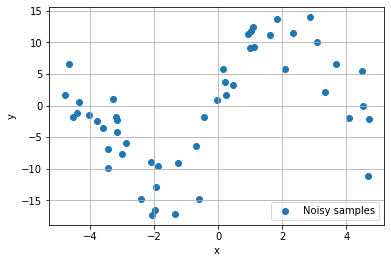

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

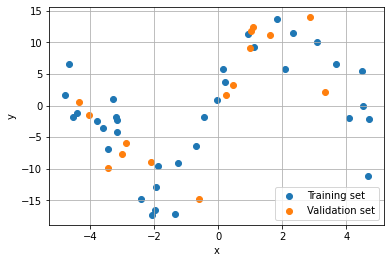

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

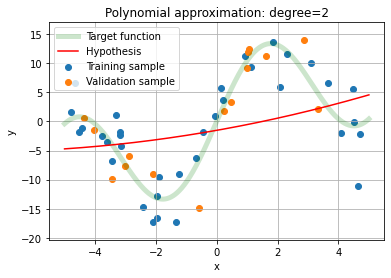

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

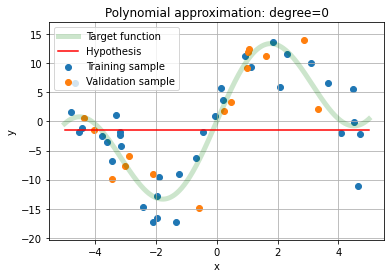

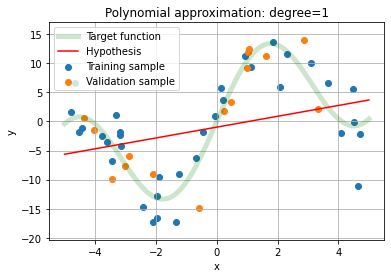

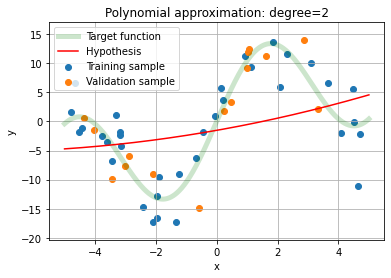

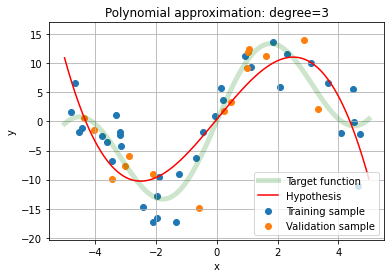

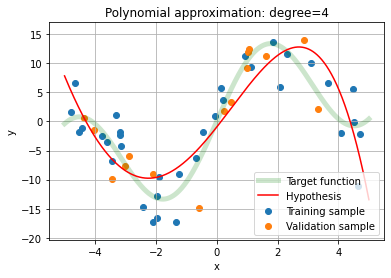

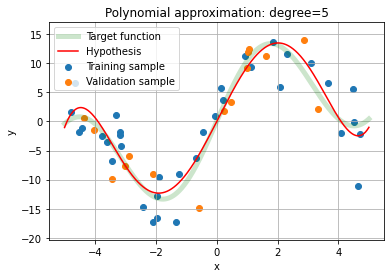

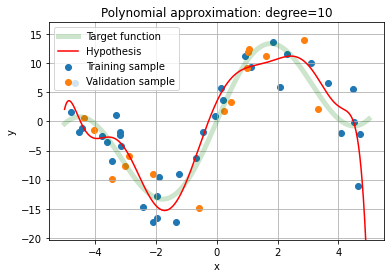

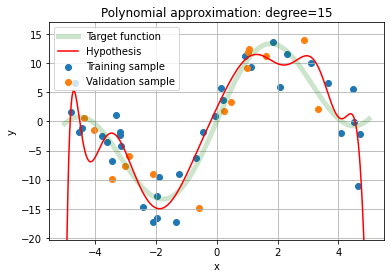

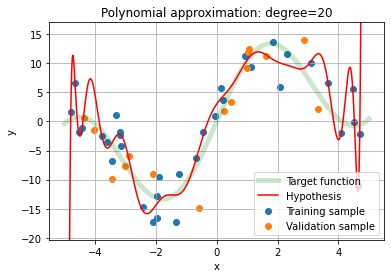

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

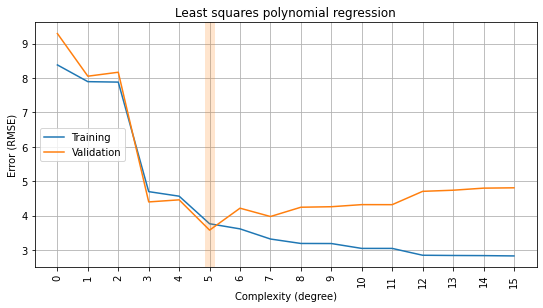

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

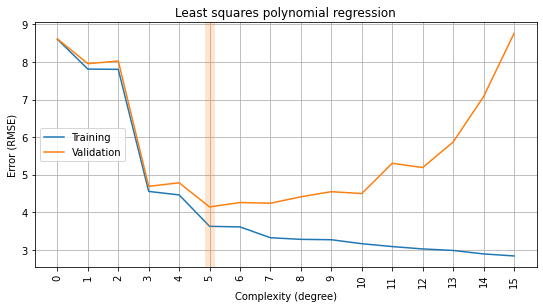

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

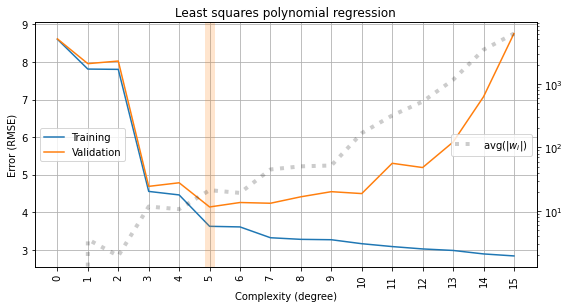

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

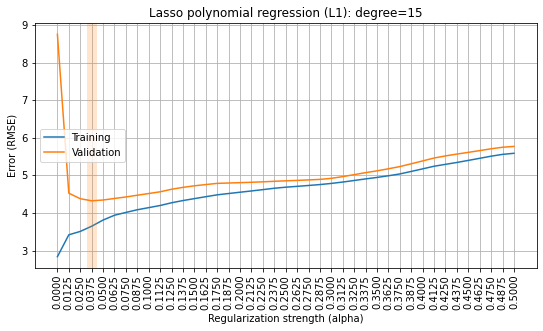

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

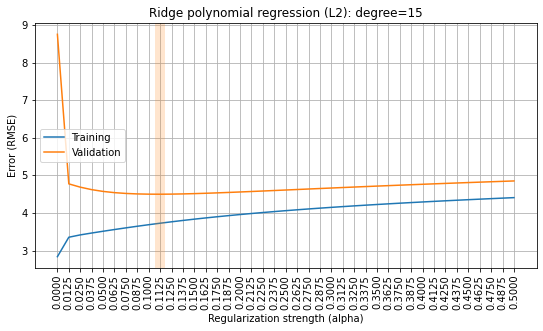

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

WARNING!

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you must collect all features together (those which were used to generate polynomials and the rest).

Модифицируем исходную функцию для создания моделей:
* добавим возможность генерировать полиномиальные фичи только для части признаков
* добавим возможность убирать либо добавлять скалирование (StandardScaler) (это понадобиться для выполнения дальнейших задач)

Так как будем использовать кросс-валидацию, оставим для финального теста 10% исходного.

In [21]:

X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.1, random_state=SEED)

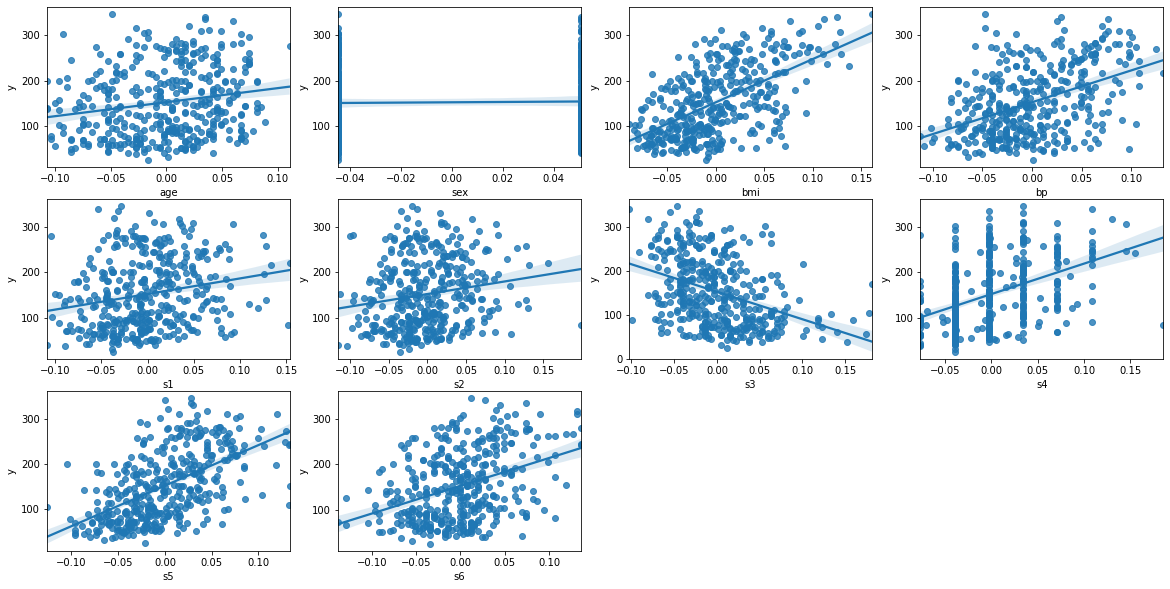

In [22]:
# Проанализируем взаимосвязь целевой переменной с независимыми переменными

plt.figure(figsize=(20, 10))
for x, y in enumerate(X_train.columns):
  plt.subplot(3,4,x+1)
  sns.regplot(x=X_train[y], y=y_train, label=y)
  plt.xlabel(y)
  plt.ylabel('y')

In [23]:

def make_model_part(degree, non_poly_feat, poly_feat, alpha=0, penalty=None, scale=True):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=100_000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=100_000) 
    
 
    preprocessing = ColumnTransformer(
        [("passthrough", "passthrough", non_poly_feat),
         ('pol', PolynomialFeatures(degree), poly_feat)])

    if scale:
        return Pipeline([
            ("preprocess", preprocessing),
            ('sca', StandardScaler()),
            ('reg', regressor)
        ])
    else:
        return Pipeline([
            ("preprocess", preprocessing),
            ('reg', regressor)
        ])

display(make_model_part(2, non_poly_feat=['feat 1'], poly_feat=['feat 2']))
display(make_model_part(2, penalty='L1', alpha=0.1, scale=False, non_poly_feat=['feat 1'], poly_feat=['feat 2']))



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['feat 1']),
                                                 ('pol', PolynomialFeatures(),
                                                  ['feat 2'])])),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['feat 1']),
                                                 ('pol', PolynomialFeatures(),
                                                  ['feat 2'])])),
                ('reg', Lasso(alpha=0.1, max_iter=100000, random_state=42))])

In [24]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES[1:]:
    results = cross_validate(make_model_part(degree, poly_feat=X_train.columns[:7].to_list(),
                                             non_poly_feat=X_train.columns[7:].to_list()),
                             X_train, y_train, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    

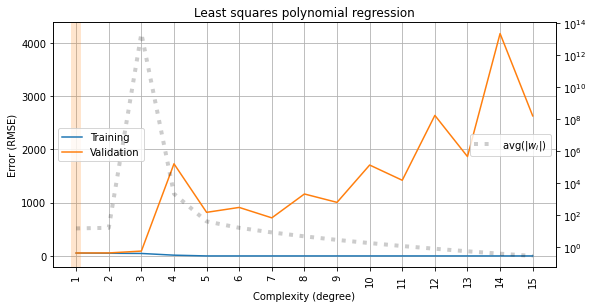

In [25]:
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

In [26]:
DEGREES[1:][np.argmin(rmse_valid)]

1

In [28]:
res = cross_validate(make_model_part(1, poly_feat=X_train.columns[:7].to_list(),
                             non_poly_feat=X_train.columns[7:].to_list()),
                             X_train, y_train, cv=5,

                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
score_test=[]
train_score = -np.mean(res['train_score'])
test_score = -np.mean(res['test_score'])
[score_test.append(mean_squared_error(y_valid, res['estimator'][x].predict(X_valid))**0.5) for x in range(5)]
print(f'RMSE on train set with degree=1: {train_score.round(2)}')
print(f'RMSE on valid set with degree=1: {test_score.round(2)}')
print(f'RMSE on test set with degree=1: {np.mean(score_test).round(2)}')

RMSE on train set with degree=1: 53.5
RMSE on valid set with degree=1: 55.16
RMSE on test set with degree=1: 52.58


Так как в данной ситуации мы имеем дело с датасетом, содержащим не одну независимую переменную, а 10, то переобучение наступает уже при генерации полиномиальных признаков 2-3 степени (это видно по графику средних значений весов модели), даже если генерируем фичи на основе пяти признаков. Необходимо учитывать, что при генерации создаются не только переменный в степенях, но и новые переменные - продукт взаимодействия исходных. То есть, при значении degree=2 из 10 исходных фич генерируются 65, при degree=3 - 285 признаков, а при degree=15 - 3 268 760 признаков.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Сократим количество фич для генерации полиномиальных признаков и количество сплитов до трех.

C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7722.156487529632, tolerance: 158.06046931818176
  model = cd_fast.enet_coordinate_descent(
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12632.205210033979, tolerance: 161.80226641509432
  model = cd_fast.enet_coordinate_descent(
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9397.308024221216, tolerance: 148.58739094339623
  model = cd_fast.enet_coordinate_descent(
C:\Users\314Dell\anaconda3\envs\studying\lib\site-package

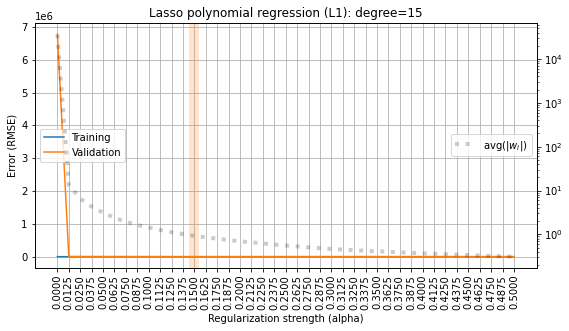

In [29]:

rmse_train_l1, rmse_valid_l1, avg_coef_l1, zero_coef_l1 = [], [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_part(degree=15, penalty='L1', alpha=alpha,
                                            poly_feat=['age', 'bmi', 's3'], 
                                             non_poly_feat=['sex', 'bp', 's1', 's2', 's4', 's5', 's6']), 
                             X_train, y_train, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l1.append(-np.mean(results['train_score']))
    rmse_valid_l1.append(-np.mean(results['test_score']))
    avg_coef_l1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    zero_coef_l1.append(        
        # average 0 coef over CV folds
        np.sum(np.mean([            
            np.abs(model['reg'].coef_)
            for model in results['estimator']
        ], axis=0)==0))
    
plot_fitting_graph(ALPHAS, rmse_train_l1, rmse_valid_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

In [30]:
ALPHAS[np.argmin(rmse_valid_l1)]

0.15000000000000002

In [31]:
# Проверим лучшую модель на тестовом сете
res = cross_validate(make_model_part(degree=15, penalty='L1', alpha=0.15,
                                             poly_feat=['age', 'bmi', 's3'], 
                                             non_poly_feat=['sex', 'bp', 's1', 's2', 's4', 's5', 's6']),
                             X_train, y_train, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
score_test=[]
train_score = -np.mean(res['train_score'])
test_score = -np.mean(res['test_score'])
[score_test.append(mean_squared_error(y_valid, res['estimator'][x].predict(X_valid))**0.5) for x in range(5)]
print(f'RMSE on train set with alpha=0.15: {train_score.round(2)}')
print(f'RMSE on valid set with alpha=0.15: {test_score.round(2)}')
print(f'RMSE on test set with alpha=0.15: {np.mean(score_test).round(2)}')

RMSE on train set with alpha=0.15: 47.6
RMSE on valid set with alpha=0.15: 73.24
RMSE on test set with alpha=0.15: 347.46


In [32]:
avg_coef_l1[:5]

[36528.801819821805,
 13.343462939500656,
 6.550499905344037,
 4.285266779061296,
 3.118861821058882]

#### L2

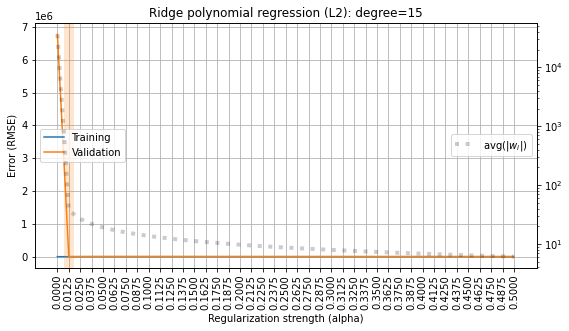

In [33]:
## your code
rmse_train_l2, rmse_valid_l2, avg_coef_l2, zero_coef_l2 = [], [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_part(degree=15, penalty='L2', alpha=alpha,
                                             poly_feat=['age', 'bmi', 's3'], 
                                             non_poly_feat=['sex', 'bp', 's1', 's2', 's4', 's5', 's6']), 
                             X_train, y_train, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l2.append(-np.mean(results['train_score']))
    rmse_valid_l2.append(-np.mean(results['test_score']))
    avg_coef_l2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    zero_coef_l2.append(        
        # average 0 coef over CV folds
        np.sum(np.mean([            
            np.abs(model['reg'].coef_)
            for model in results['estimator']
        ], axis=0)==0))
       
plot_fitting_graph(ALPHAS, rmse_train_l2, rmse_valid_l2, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   custom_metric=avg_coef_l2, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

In [34]:
ALPHAS[np.argmin(rmse_valid_l2)]

0.0125

In [35]:
# Проверим лучшую модель на тестовом сете
res = cross_validate(make_model_part(degree=15, penalty='L2', alpha=0.0125,
                                    poly_feat=['age', 'bmi', 's3'], 
                                    non_poly_feat=['sex', 'bp', 's1', 's2', 's4', 's5', 's6']),
                             X_train, y_train, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
score_test=[]
train_score = -np.mean(res['train_score'])
test_score = -np.mean(res['test_score'])
[score_test.append(mean_squared_error(y_valid, res['estimator'][x].predict(X_valid))**0.5) for x in range(5)]
print(f'RMSE on train set alpha=0.0125: {train_score.round(2)}')
print(f'RMSE on valid set with alpha=0.0125: {test_score.round(2)}')
print(f'RMSE on test set with alpha=0.0125: {np.mean(score_test).round(2)}')

RMSE on train set alpha=0.0125: 38.58
RMSE on valid set with alpha=0.0125: 2220.13
RMSE on test set with alpha=0.0125: 3945.67


In [36]:
avg_coef_l2[:5]

[36528.801819821805,
 37.37190647937652,
 26.621306750066157,
 21.923254220953584,
 19.118629931162033]

#### Summary

Очевидно, что в исходных моделях без регуляризации (альфа=0) среднее значение по весам моделей очень большое (36528.80). Однако, после введения регуляризации веса моделей падают, причем крайне сильно (при альфа=0.0125 среднее значение весов по модели с L1-регуляризацией составляет 13.44, для L2-регуляризации - 37.37). В дальнейшем веса продолжают падать, однако более плавно, что видно по графикам.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

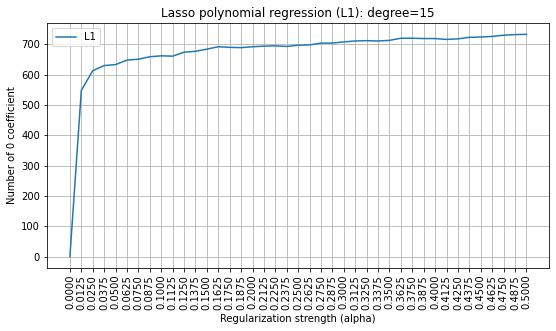

In [37]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, zero_coef_l1, label='L1')
plt.title('Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Number of 0 coefficient')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='upper left');
## your code

#### L2

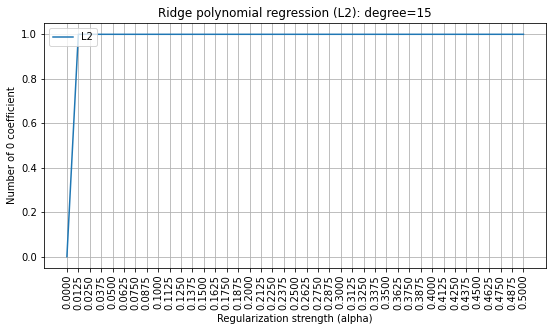

In [38]:
## your code
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, zero_coef_l2, label='L2')
plt.title('Ridge polynomial regression (L2): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Number of 0 coefficient')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='upper left');

#### Summary

L2 регуляризация снижает веса, однако не обнуляет их, веса только стремятся к нулю. В свою очередь L1 регуляризация может обнулять веса, следовательно признаки с данными коэффициентами не учитываются в предсказательной модели. Если посмотреть на графики количества признаков с нулевыми коэффициентами для L1 и L2 регуляризации, видно, что количество таких признаков для L1-регуляризации меняется в зависимости от значения альфа, достигая 733 (из 823 возможных), в то время как для L2 регуляризации количество таких коэффициентов остается равным единице независимо от значения альфа. Данный вес присваивается признаку, все значения которого равны единицам и который создается в ходе генерации полиномиальных признаков.\ 
Таким образом, модели с L1 регуляризацией можно использовать для отбора признаков, так как при обнулении коэффициентов значения признаков не оказывают влияния на модель, следовательно их можно исключать из модели при условии, что метрики при этом улучшаются.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [39]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [40]:

rmse_valid_l1_unscale, rmse_valid_l1_scale = [], []
for degree in DEGREES[1:]:
 
    results = cross_validate(make_model_part(degree=degree, penalty='L1', alpha=0.15, scale=True,
                                            poly_feat=[0, 1, 2], non_poly_feat=[]), 
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')

    rmse_valid_l1_scale.append(-np.mean(results['test_score']))

    results = cross_validate(make_model_part(degree=degree, penalty='L1', alpha=0.15, scale=False,
                                            poly_feat=[0, 1, 2], non_poly_feat=[]),
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_valid_l1_unscale.append(-np.mean(results['test_score']))

C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.73130434157834, tolerance: 0.11026933349064255
  model = cd_fast.enet_coordinate_descent(
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.17560664339682, tolerance: 0.146832047311351
  model = cd_fast.enet_coordinate_descent(
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.60168496650847, tolerance: 0.16461610318744452
  model = cd_fast.enet_coordinate_descent(
C:\Users\314Dell\anaconda3\envs\studying\lib\site-package

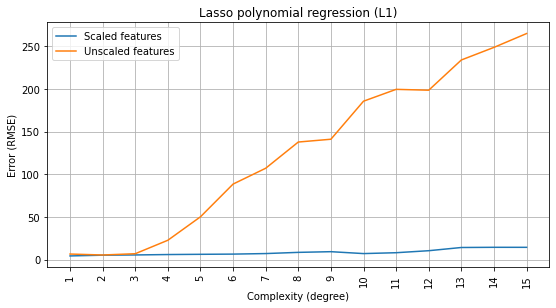

In [41]:
plt.figure(figsize=(9, 4.5))
plt.plot(DEGREES[1:], rmse_valid_l1_scale, label='Scaled features')
plt.plot(DEGREES[1:], rmse_valid_l1_unscale, color='C1', label='Unscaled features')
plt.title('Lasso polynomial regression (L1)')
plt.xlabel('Complexity (degree)')
plt.ylabel('Error (RMSE)')
plt.grid(True)
plt.xticks(DEGREES[1:], rotation='vertical')
plt.legend(loc='upper left')        
       
plt.show()

#### L2

In [42]:
## your code
rmse_valid_l2_unscale, rmse_valid_l2_scale = [], []
for degree in DEGREES[1:]:
    results = cross_validate(make_model_part(degree=degree, penalty='L2', alpha=0.0125, 
                                             scale=True, poly_feat=[0, 1, 2], non_poly_feat=[]), 
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_valid_l2_scale.append(-np.mean(results['test_score']))
    results = cross_validate(make_model_part(degree=degree, penalty='L2', alpha=0.0125, 
                                              scale=False, poly_feat=[0, 1, 2], non_poly_feat=[]), 
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_valid_l2_unscale.append(-np.mean(results['test_score']))

C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.05143e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.33999e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.3759e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear

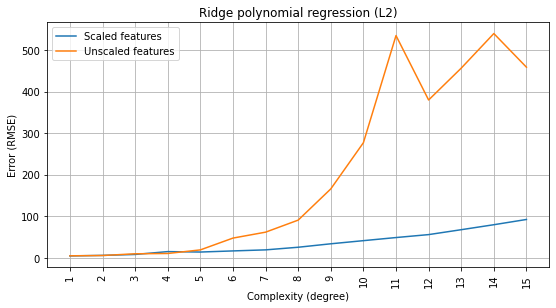

In [43]:
plt.figure(figsize=(9, 4.5))
plt.plot(DEGREES[1:], rmse_valid_l2_scale, label='Scaled features')
plt.plot(DEGREES[1:], rmse_valid_l2_unscale, color='C1', label='Unscaled features')
plt.title('Ridge polynomial regression (L2)')
plt.xlabel('Complexity (degree)')
plt.ylabel('Error (RMSE)')
plt.grid(True)
plt.xticks(DEGREES[1:], rotation='vertical')
plt.legend(loc='upper left')        
       
plt.show()

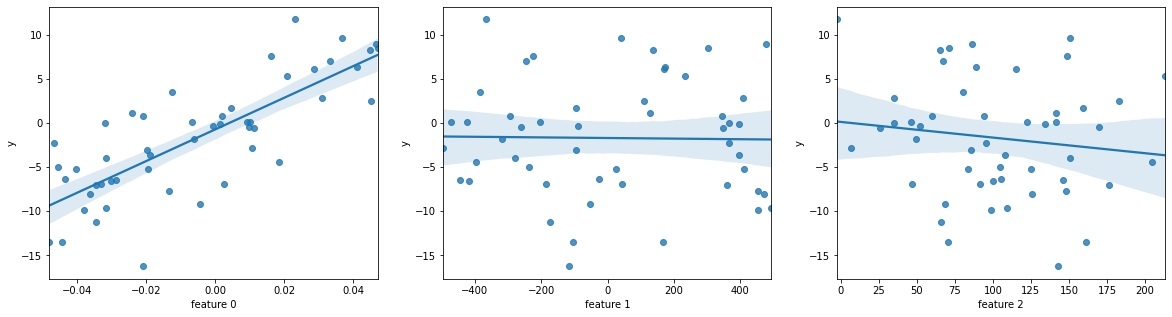

In [44]:
# Проанализируем взаимосвязь целевой переменной с независимыми переменными

plt.figure(figsize=(20, 5))
for x in range(3):
  plt.subplot(1,3,x+1)
  sns.regplot(x=X_hw[:, x], y=y_hw, label=f'feature {x}')
  plt.xlabel(f'feature {x}')
  plt.ylabel('y')


In [45]:
# Построим линейную регрессию без регуляризации

rmse_train_l0, rmse_valid_l0, avg_coef_l0 = [], [], []
for scale in [True, False]:    
    results = cross_validate(make_model_part(degree=1, scale=scale, poly_feat=[0, 1, 2], non_poly_feat=[]), 
                             X_hw, y_hw, cv=5, 
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l0.append(-np.mean(results['train_score']))
    rmse_valid_l0.append(-np.mean(results['test_score']))
    avg_coef_l0.append(        
        # average over CV folds
        np.mean([model['reg'].coef_
            for model in results['estimator']], axis=0))
print('Linear Regression')
print(f'RMSE for validation set: {np.array(rmse_valid_l0).round(2)}')
print(f'Model coefficents with standartization: {avg_coef_l0[0]}')
print(f'Model coefficents without standartization: {avg_coef_l0[1]}')

Linear Regression
RMSE for validation set: [4.25 4.25]
Model coefficents with standartization: [ 0.          5.10688445  0.14428253 -0.59772916]
Model coefficents without standartization: [ 0.00000000e+00  1.78952210e+02  4.62755795e-04 -1.19523899e-02]


#### Summary



Коэффициенты (веса) линейной модели обусловливают степень включения значений независимых переменных в предсказания целевой переменной. Однако, если две независимые переменные будут вносить одинаковый вклад в целевую, но при этом диапазон их значений будет отличаться, также будут отличаться и коэффициенты, что может привести к некорректным выводам и допущениям.\
В нашем примере видна четкая линейная связь между целевой переменной и первым признаком feature 0, в свою очередь с признаком feature 1 связь фактические отсутствуте, оданако по диапазону значений данные признаки крайне отличаются
[-0.05, 0.05] для первого признака, и [-494.87, 493.57] для второго.\
В результате, при использовании линейной регрессии без регуляризации видим, что коэффициенты в случае нескалированных признаков для данных фич составляют 178.95	и 0.0005, а в случае скалированных - 5.10	и 0.14, что лучше отражает реальный вклад данных признаков в целевую функцию модели.\
Кроме того, не все алгоритмы будут работать на данных с разными диапазонами. Например целевые функции линейной регрессии с L1 и L2 регуляризациями предполагают, что значения всех признаки находятся вблизи нуля и имеют дисперсию сходного уровня. Если разброс значений дисперсии одного признака на порядок больше, чем у других признаков, этот признак будет больше влиять на целевую функцию, и другие признаки не будут учитываться корректно. Модель может и вовсе не сойтись. Например, в случае регрессий с L1 и L2 мы наблюдаем на графиках рост ошибки с ростом количества признаков и, соответственно, диапазона их значений, а также появляются сообщения о невозможности использования целевых функций.\
 Поэтому, хотя для некоторых моделей стандартизация и не является критичной, лучше всегда приводить признаки к сходных диапазонам, например с помощью StandardScaler. Суть данной стандартизации включает центрирование случайной величины (разность между значением случайной величиной и ее средним значением) и нормирование (деление на стандартное отклонение).